<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Fast image retrieval

In the notebook [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) we find the most similar reference image by computing the distances between a query image and *all* reference images using the function `compute_distances()`. While computing the L2 distance between two images is fast, for large datasets of tens of thousands of images this exhaustive brute-force search can be a bottleneck for real-time applications.

To speed up image retrieval, this notebook shows how to implement an approximate nearest neighbor method designed to work well for large datasets (N) and high dimensional DNN features (D). We use Ball Tree, a popular approach, which has query time growing as O\[D\*log(N)\], compared to O\[D\*N\] for brute force. 

## Initialization

In [21]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [22]:
# Regular python libraries
import sys
import numpy as np
from pathlib import Path
import random

import scrapbook as sb

# fast.ai
import fastai
from fastai.vision import (
    load_learner,
    accuracy,
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
    partial,
)

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    compute_distances,
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import (
    plot_comparative_set,
    plot_distances,
    plot_ranks_distribution,
    plot_recalls,
)

In [23]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Cuda is not available. Fast.ai/Torch is using CPU


## Data preparation
We start with parameter specifications and data preparation. We use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. 

In [33]:
# Data location
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# DNN configuration
BATCH_SIZE = 16
ARCHITECTURE = models.resnet18
IM_SIZE = 300

We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

In [64]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data = (
    ImageList.from_folder(DATA_PATH)
    #.split_none()
    .split_by_rand_pct(valid_pct=0.15, seed=20)
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

## Load model

In this example we will use a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet. In practice one will want to load a model here which was trained using the [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) notebook using the code:
```python
    learn = load_learner(".", 'image_similarity_01_model')
```

In [68]:
learn = load_learner(".", 'image_similarity_01_model')
# learn = cnn_learner(
#     data,
#     ARCHITECTURE,
#     metrics=[accuracy],
#     callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
#     ps=0 #Leave dropout at zero. Higher values tend to perform significantly worse
# )

## Feature extraction

We use the output of the penultimate layer (ie 512 floating points vector) as our image representation.

In [69]:
# Use penultimate layer as image representation
embedding_layer = learn.model[1][-2] 
print(embedding_layer)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [70]:
#Compute DNN features for all validation images
ref_features = compute_features_learner(data, DatasetType.Valid, learn, embedding_layer)
print(
    f"Computed DNN features for {len(list(ref_features))} images, \
each consisting of {len(ref_features[list(ref_features)[0]])} floating point values."
)

20
20
Computed DNN features for 20 images, each consisting of 512 floating point values.


## Image Retrieval Example
The cell below shows how to find and display the most similar images in the validation set for a given query image (which we also select from the validation set). This example is similar to the one shown in the [00_webcam.ipynb](https://github.com/microsoft/ComputerVision/tree/master/similarity/notebooks/00_webcam.ipynb) notebook. 

We use the L2 distance which is defined as <sup> $ \sqrt{\sum_{i=1}^{n}{(F_{q}[i] - F_{r}[i])^{2}}} $ </sup> where $F_{q}$ and $F_{r}$ are the features of a query image and a reference image respectively, and $n=512$ is their dimensionality. By default, we normalize the feature vectors $F_{q}$ and $F_{r}$ to be unit-length, i.e. have a magnitude ||$F$|| of 1, before computing the L2 distance. One could also use other distances measures, such as L1 or cosine similarity, however L2 with unit-length normalized feature vectors seems to work well in practice. 

Query image path: /data/home/pabuehle/Desktop/ComputerVision/data/fridgeObjects/can/15.jpg
Query feature dimension: 512


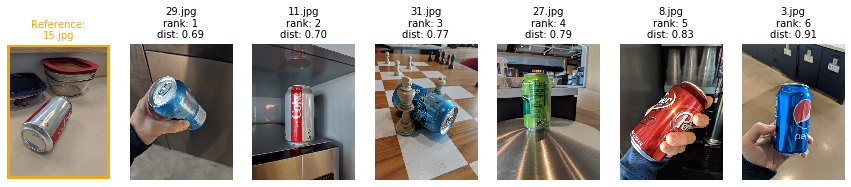

In [12]:
# Get the DNN feature for the query image
query_im_path =  str(data.valid_ds.items[1])
query_feature = valid_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == 512

# Compute the distances between the query and all reference images
distances = compute_distances(query_feature, valid_features)
plot_distances(distances, num_rows=1, num_cols=7, figsize=(15,5))

In the cell below, we demonstrate how to do fast image retrieval using scikit-learn's [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object. Note that we normalized the embeddings, and chose "Euclidean" distance, to match our "L2" distance measure in this notebook.


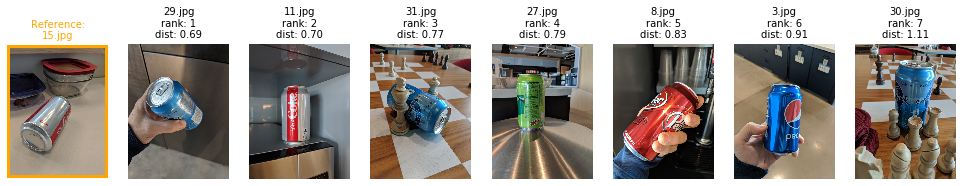

In [19]:
from sklearn.neighbors import NearestNeighbors

# Normalize query and all reference features to be unit length
query_feature /= np.linalg.norm(query_feature, 2)
reference_features = np.array(list(valid_features.values()))
reference_features /= np.linalg.norm(reference_features, axis=1)[:,None]

# Build nearest neighbor object using the reference set
nn = NearestNeighbors(n_neighbors = 10, algorithm='auto', metric='euclidean').fit(reference_features)

# Query the nearest neighbor object to find all reference images which are similar to the query image
query_feature = np.reshape(query_feature, (-1, 512))
approx_distances, approx_im_indices = nn.kneighbors(query_feature)

# Display the results
approx_im_paths = [str(data.valid_ds.items[i]) for i in approx_im_indices[0]]
plot_distances(list(zip(approx_im_paths, approx_distances[0])), 
               num_rows=1, num_cols=8, figsize=(17,5))

In [20]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
sb.glue("query_feature", query_feature)
sb.glue("reference_features", reference_features)